In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Let's take a look at our data

In [42]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data  = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_subData = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
print("Training Data")
print(train_data.head(2))
print("Testing Data")
print(test_data.head(2))
print("Gender submissionData")
print(gender_subData.head(2))

Training Data
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   

   Parch     Ticket     Fare Cabin Embarked  
0      0  A/5 21171   7.2500   NaN        S  
1      0   PC 17599  71.2833   C85        C  
Testing Data
   PassengerId  Pclass                              Name     Sex   Age  SibSp  \
0          892       3                  Kelly, Mr. James    male  34.5      0   
1          893       3  Wilkes, Mrs. James (Ellen Needs)  female  47.0      1   

   Parch  Ticket    Fare Cabin Embarked  
0      0  330911  7.8292   NaN        Q  
1      0  363272  7.0000   NaN        S  
Gender submissionData
   PassengerId  Survived
0          892         0
1          893         1


*Seems like the testing data can be used in combination with Gender submission data*

# Let us check for nan values first

In [43]:
print(train_data.isnull().sum()) 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Seems like Age and Cabin data need some processing:
* Some of the age values can be filled using the title before names
* Cabin and passenger class might be inter-related 

In [44]:
#Dropping age values for now
train_data.dropna(subset = ['Age'],inplace = True)

# Let us check for correlations between different features

First we must encode non-numeric features into numeric values using LabelEncoder

In [50]:
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
train_data['Cabin'] = le.fit_transform(train_data['Cabin'].astype(str))


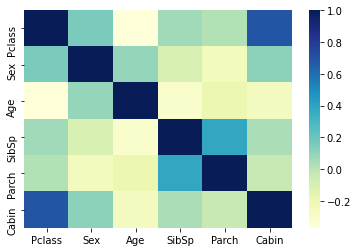

In [51]:
sns.heatmap(train_data.loc[:,['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin']].corr(), cmap="YlGnBu")

*Notice that Cabin and Pclass hre significantly correlated.*

Since a lot of Cabin data is missing we'll use Pclass instead of Cabin

In [52]:
X,y = train_data.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']], train_data.loc[:,'Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)
svc = SVC()
clf = GridSearchCV(svc, {
    'kernel':('linear', 'rbf', 'poly'),
    'C': [0.1,1,10,100]})

In [55]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ('linear', 'rbf', 'poly')})

In [56]:
result_df = pd.DataFrame(clf.cv_results_)
print(result_df)
print(clf.best_score_)
print(clf.best_params_)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.009924      0.002094         0.002154        0.000114     0.1   
1        0.009006      0.000128         0.003050        0.000085     0.1   
2        0.006480      0.000412         0.002226        0.000022     0.1   
3        0.018410      0.002970         0.002274        0.000068       1   
4        0.009060      0.000194         0.002918        0.000057       1   
5        0.007105      0.000276         0.002207        0.000019       1   
6        0.097911      0.014584         0.002452        0.000048      10   
7        0.008962      0.000288         0.002827        0.000065      10   
8        0.012898      0.002592         0.002448        0.000186      10   
9        0.988091      0.204302         0.002722        0.000511     100   
10       0.014287      0.001330         0.002783        0.000047     100   
11       0.018009      0.003453         0.002914        0.000578     100   

   param_ke

*SVC with rbf kernel at c = 100 gave the best results for now.*